In [1]:
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import pprint
import os
from shutil import copyfile
from tqdm.notebook import tqdm
import pandas as pd
import h5py
from numba import jit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# test model performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

# limit gpu memory
import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)
        
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
data_dir = Path('./data')
proximity_map_path = Path('./data/pmap.h5')
grayscale_proximity_map_path = Path('./data/grayscale_pmap.h5')

image_dir = Path('./data/imgs')

img_list = os.listdir(image_dir)
img_list.sort()

# Prepare dataset

In [3]:
img_data = []
img_mask = []
coord_data = []
flatten_arr = []
with h5py.File(proximity_map_path, 'r') as file:
    for i in tqdm(range(len(img_list))):
        img_arr = file.get('img/{:03d}'.format(i))[:]
        pmap_arr = file.get('pmap/{:03d}'.format(i))[:]
        coord_arr = file.get('xy/{:03d}'.format(i))[:]
        
        coord_data.append(coord_arr)
        
        img_data.append(img_arr)
        img_mask.append(pmap_arr)

In [4]:
train_data, train_mask = img_data[:100], img_mask[:100]
val_data, val_mask = img_data[100:120], img_mask[100:120]
test_data, test_mask = img_data[120:], img_mask[120:]

In [5]:
def random_crop(x, y, size, number):
    x_result = []
    y_result = []
    max_index = len(x)
    
    for i in tqdm(range(number)):
        index = np.random.randint(low=0, high=max_index)
        item_size = y[index].shape[0]
        x_loc = np.random.randint(low=0, high=item_size - size)
        y_loc = np.random.randint(low=0, high=item_size - size)
        
        crop_x = x[index][x_loc: x_loc + size, y_loc: y_loc + size]
        crop_y = y[index][x_loc: x_loc + size, y_loc: y_loc + size]
        
        x_result.append(crop_x)
        y_result.append(crop_y)
        
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    y_result = np.resize(y_result, (number, size, size, 1))*200.
    return x_result, y_result

In [6]:
X_train, y_train = random_crop(train_data, train_mask, 128, 10000)
print(X_train.shape, y_train.shape)


(10000, 128, 128, 3) (10000, 128, 128, 1)


1.4162963189851114 1.4162963189851114


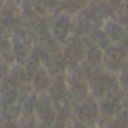

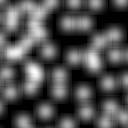

1.514525385490444


In [7]:
sample_nun = 2
x_img = Image.fromarray(X_train[sample_nun])
resize_y = np.resize(y_train[sample_nun], (128, 128))
print(np.max(resize_y), np.max(y_train[sample_nun]))
scale_y = resize_y * (255./np.max(resize_y))
y_img = Image.fromarray(scale_y.astype('uint8'))
display(x_img)
display(y_img)
print(np.max(y_train[0]))

In [12]:
X_val, y_val = random_crop(val_data, val_mask, 128, 2000)
print(X_val.shape, y_val.shape)


(2000, 128, 128, 3) (2000, 128, 128, 1)


In [13]:
data_gen_args = dict(featurewise_center=False, featurewise_std_normalization=False, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

image_datagen.fit(X_train)
mask_datagen.fit(y_train)

seed = 100
image_generator = image_datagen.flow(X_train, seed=seed, batch_size=32, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32, shuffle=True)
train_generator = zip(image_generator, mask_generator)

In [14]:
val_data_gen_args = dict(featurewise_center=False, featurewise_std_normalization=False, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
val_mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_mask_gen_args)

val_image_datagen.fit(X_val)
val_mask_datagen.fit(y_val)

seed = 100
val_image_generator = val_image_datagen.flow(X_val, seed=seed, batch_size=32, shuffle=True)
val_mask_generator = val_mask_datagen.flow(y_val, seed=seed, batch_size=32, shuffle=True)
val_generator = zip(val_image_generator, val_mask_generator)

# Build model

## Conv model

In [104]:
# from tensorflow.keras import optimizers

# def prepare_encoder(config, inputs):
#     regularizer = keras.regularizers.l2(0.001)

#     prev_output = inputs
#     for i in range(len(config)):
#         conv = layers.Conv2D(filters=config[i][0],
#                              kernel_size=config[i][1],
#                              kernel_initializer='he_normal',
#                              padding='SAME',
#                              activation='relu',
#                              kernel_regularizer=regularizer)(prev_output)
#         if config[i][2]:
#             bn = layers.BatchNormalization()(conv)
#         else: 
#             bn = conv
            
#         if config[i][3]:
#             max_pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(bn)
#         else:
#             max_pool = bn
#         prev_output = max_pool
        
#     return prev_output

# def prepare_decoder(config, inputs):
#     regularizer = keras.regularizers.l2(0.001)

#     prev_output = inputs
#     for i in range(len(config)):
#         if i == len(config)-1:
#             acti = 'sigmoid'
#         else:
#             acti='relu'
            
#         conv = layers.Conv2D(filters=config[i][0],
#                              kernel_size=config[i][1],
#                              kernel_initializer='he_normal',
#                              padding='SAME',
#                              activation=acti,
#                              kernel_regularizer=regularizer)(prev_output)
            
#         if config[i][2]:
#             max_pool = keras.layers.UpSampling2D(size=(2,2))(conv)
#         else:
#             max_pool = conv
#         prev_output = max_pool
        
#     return prev_output
        

# def prepare_conv_auto_encoder(config):
#     input_shape = config['input_size']
#     output_size = config['output_size']
#     loss_function = config['loss_function']
#     regularizer = keras.regularizers.l2(0.001)
    
#     inputs = keras.Input(shape=input_shape)
#     s = tf.keras.layers.Lambda(lambda x: x / 255.)(inputs)

#     encoder_config = [[32, (3, 3), False, True],
#                       [64, (3, 3), False, False],
#                       [128, (3, 3), False, True],
#                       [256, (3, 3), False, False]]

#     encoder = prepare_encoder(encoder_config, s)

    
#     decoder_config = [[256, (5, 5), False],
#                       [256, (5, 5), True],
#                       [1, (5, 5), True]]
                    
#     decoder = prepare_decoder(decoder_config, encoder)
# #     output = layers.Conv2D(filters=1,
# #                              kernel_size=(1, 1),
# #                              padding='SAME',
# # #                              activation='tanh',
# #                              kernel_regularizer=regularizer)(decoder)
# #     avg = layers.AveragePooling2D(pool_size=(25, 25), strides=1, padding='same')(decoder)

#     output = decoder
# #     output = layers.Reshape(input_shape)(output_pre)
#     full_model = keras.Model(inputs=inputs,
#                              outputs=output)


#     full_model.compile(optimizer='adam',
#                        loss=loss_function,
#                        metrics=['mae'])
#     return full_model

# test_config={
#     "input_size": (128, 128, 3),
#     "output_size": (128, 128, 1),
#     "loss_function": 'mse'
# }

# model = prepare_conv_auto_encoder(test_config)

# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)
# print(model.summary())

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda_12 (Lambda)           (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 64, 64, 128)       73856     
______________________________________

## Unet

In [12]:
from tensorflow.keras import optimizers

def custom_loss(layer):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)
   
    # Return a function
    return loss

def prepare_unet(config):
    input_shape = config['input_size']
    output_size = config['output_size']
    loss_function = config['loss_function']
    regularizer = keras.regularizers.l2(0.001)
    

    #Build the model
    inputs = tf.keras.layers.Input(input_shape)
    s = tf.keras.layers.Lambda(lambda x: x / 255.)(inputs)
    
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer,  padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                kernel_regularizer=regularizer, padding='same')(c9)
 
#     outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    outputs = tf.keras.layers.Conv2D(1, (1, 1))(c9)

    full_model = keras.Model(inputs=inputs,
                             outputs=outputs)


    full_model.compile(optimizer='adam',
                       loss=loss_function,
                       metrics=['mae'])
    return full_model

test_config={
    "input_size": (128, 128, 3),
    "output_size": (128, 128, 1),
    "loss_function": 'mse'
}

model = prepare_unet(test_config)

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)
print(model.summary())

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
________

In [13]:
def train_model(model,
                generator,
                epochs,
                batch_size,
                suffix='',
                save_dir=None,
                sched= None):
    
    if save_dir is not None:
        mc = ModelCheckpoint(str(save_dir /
                                 (suffix + '_model_{epoch:04d}.h5')),
                             save_freq='epoch')
        callbacks = [mc]
        if sched is not None:
            callbacks.append(sched)
        history = model.fit_generator(generator,
                            label_train,
                            epochs=epochs,
                            callbacks=callbacks,
                            validation_split=0.2,
                            shuffle=True)

    else:
        history = model.fit(data_train,
                            label_train,
                            epochs=epochs,
                            batch_size=batch_size)

    return history

In [14]:
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.keras import backend as K

def weighted_bce(y_true, y_pred):
    weights = (y_true * 59.) + 1.
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

def weighted_mse(y_true, y_pred):
    weights = (y_true * 59.) + 1.
    mse = K.square(y_pred - y_true)
    weighted_mse = K.mean(mse * weights)
    return weighted_mse

# (None, None, None, None) (None, 128, 128, 1) () Tensor("loss/conv2d_559_loss/Mean_1:0", shape=(), dtype=float32)
# (None, None, None, None) (None, 128, 128, 1) (None, 128, 128)
# (None, None, None, None) (None, 128, 128, 1) ()
# (None, None, None, None) (None, 128, 128, 1) () Tensor("loss/conv2d_619_loss/Mean:0", shape=(), dtype=float32)

config={
    "input_size": (128, 128, 3),
    "output_size": (128, 128, 1),
    "loss_function": weighted_mse
}

early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = None
model = prepare_unet(config)
model.fit(train_generator, steps_per_epoch=int(np.ceil(len(X_train)/32)), callbacks=[early_stop],
                    epochs=100, validation_data=val_generator, validation_steps=int(np.ceil(len(X_val)/32)))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 63 steps
Epoch 1/100
313/313 [==============================] - 41s 130ms/step - loss: 3.5926 - mae: 0.3221 - val_loss: 3.0880 - val_mae: 0.2814
Epoch 2/100
313/313 [==============================] - 36s 114ms/step - loss: 2.6775 - mae: 0.3151 - val_loss: 2.6704 - val_mae: 0.2877
Epoch 3/100
313/313 [==============================] - 37s 118ms/step - loss: 2.4071 - mae: 0.3135 - val_loss: 2.5140 - val_mae: 0.2860
Epoch 4/100
313/313 [==============================] - 37s 118ms/step - loss: 2.2502 - mae: 0.3121 - val_loss: 2.3637 - val_mae: 0.3003
Epoch 5/100
313/313 [==============================] - 37s 117ms/step - loss: 2.1623 - mae: 0.3119 - val_loss: 2.3169 - val_mae: 0.2879
Epoch 6/100
313/313 [==============================] - 37s 117ms/step - loss: 2.0964 - mae: 0.3108 - val_loss: 2.2415 - val_mae: 0.2887
Epoch 7/100
313/313 [==============================] - 37s 117ms/step - loss: 2.0499 - mae:

In [ ]:

# config={
#     "input_size": (128, 128, 3),
#     "output_size": (128, 128, 1),
#     "loss_function": 'mse'
# }

# early_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# model = None
# model = prepare_conv_auto_encoder(config)
# model.fit(train_generator, steps_per_epoch=int(np.ceil(len(X_train)/32)), callbacks=[early_stop],
#                     epochs=100, validation_data=val_generator, validation_steps=int(np.ceil(len(X_val)/32)))

In [21]:
model.save(Path('./models/otometry_rgb_60_mse.h5'))

In [222]:


model = load_model(Path('./models/otometry_rgb_60_mse.h5'), compile=False)

# Test model

In [18]:
X_test, y_test = random_crop(test_data, test_mask, 128, 1)
print(X_test.shape, y_test.shape)
result = model.predict(X_test)


(1, 128, 128, 3) (1, 128, 128, 1)


0.8465848
(128, 128)


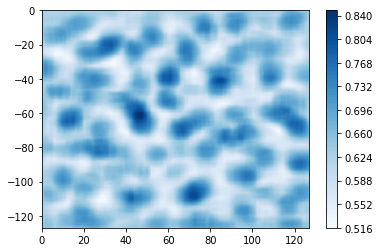

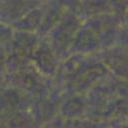

In [19]:
import matplotlib.pyplot as plt
y = np.resize(result, (128, 128))
print(np.max(y))
print(y.shape)
X = np.arange(0, len(y))
plt.contourf(X, -X, y, 100, cmap='Blues')
plt.colorbar()
plt.show()

y = np.resize(X_test[0], (128, 128, 3))
im = Image.fromarray(y)
display(im)

1.7433354643264023
(128, 128)


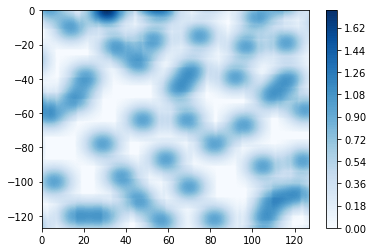

In [20]:
import matplotlib.pyplot as plt
y = np.resize(y_test[0], (128, 128))
print(np.max(y))
print(y.shape)
X = np.arange(0, len(y))
plt.contourf(X, -X, y, 100, cmap='Blues')
plt.colorbar()
plt.show()